In [1]:
# If you've done any work on Python as part of your course so far, the chances are you've 
# already used Numpy and MatPlotLib. In case you haven't, or in case you're working 
# virtually on MyBinder, you can install the packages that are needed for this model code 
# to work, you can use this command. 
# Uncomment your preferred method for downloading and organising packages

pip install numpy matplotlib pandas
#conda install -c conda-forge numpy matplotlib pandas

SyntaxError: invalid syntax (<ipython-input-1-cdda64ec3ede>, line 7)

In [2]:
# Carbon cycle box model for undergraduate and masters students - Oceans and Climate
# Uses a simple forwards Euler method 
# Based on the schematic of Ciais et al. (2013, IPCC) and Walker and Kasting (1992, Global and Planetary Change) 
# Compiled in MATLAB by Lewis Alcott (lewis.alcott@bristol.ac.uk) and converted to Python by Michael Henehan (Michael.Henehan@bristol.ac.uk)

# When Python sees the '#' sign it skips to the next line without
# reading any of the text. The text is refered to as 'comments' and are notes to the 
# human user explaining the function of the code..
# Good code has lots of comments!! If you use this as the starting material to build or design your own model, then be sure to add plenty of comments to explain what you've done! 

# importing packages that are needed
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# ----------------------------- # Model setup # ----------------------------- 
nsteps = 2600 # sets the number of model steps
dt = 0.1 # sets the timestep size, in years

In [3]:
# Preallocate arrays - this makes empty arrays to hold the model results (this speeds up the code, 
# because we now just have to change the values instead of making a new array each timestep)

Atmospheric_CO2 = np.full(nsteps, np.nan) 
Atmospheric_pCO2 = np.full(nsteps, np.nan) 
Surface_Ocean_DIC = np.full(nsteps, np.nan) 
Deep_Ocean_DIC = np.full(nsteps, np.nan) 
Ocean_Biota = np.full(nsteps, np.nan) 
Terrestrial_Biota = np.full(nsteps, np.nan) 
Soil = np.full(nsteps, np.nan) 
t = np.full(nsteps, np.nan) 
pH = np.full(nsteps, np.nan) 
T_surf = np.full(nsteps, np.nan)

In [7]:
# Initial conditions - Sets the starting values of the model reservoirs
# Values are all in Pg C, and most are simplified/converted from Walker and Kasting (1992)
# Note, these are meant to represent pre-industrial reservoirs
Atmospheric_CO2[0] = 589 
Surface_Ocean_DIC[0] = 900 
Deep_Ocean_DIC[0] = 37100 
Ocean_Biota[0] = 3 
Terrestrial_Biota[0] = 550 
Soil[0] = 1500 
t[0] = 1750 # sets the start year for the model to 1750 CE


In [9]:
# ----------------------------- # Model loop # ----------------------------- 
for n in range(nsteps): 
    # First will calculate model parameters and processes at this timestep
    # All values are calculated in GtC per year
    # Global parameters 
    Atmospheric_pCO2[n] = Atmospheric_CO2[n] / 2.124   # A simplified formula used to approximate the partial pressure of carbon dioxide from the total CO2 reservoir - 2.124 Pg C per ppm CO2 
    Climate_Sensitivity = 3 # Assumes a climate sensitivity of 3˚/doubling of CO2
    Global_Temperature_Change = Climate_Sensitivity * np.log(Atmospheric_pCO2[n] / 280) / np.log(2)
    # Terrestrial parameters 
    Resp_T_Sensitivity = 0.01
    # Terrestrial processes 
    F_Terrestrial_Photosynthesis = 110 * (Atmospheric_pCO2[n] / 280)**0.5 
    F_Terrestrial_Biota_Respiration = 0.5 * F_Terrestrial_Photosynthesis 
    F_Soil_Respiration = 54 * (Soil[n] / Soil[0]) * (1 + Resp_T_Sensitivity * Global_Temperature_Change) 
    F_Litter_Fall = 55 * (Terrestrial_Biota[n] / Terrestrial_Biota[0]) 
    F_Runoff = 1 * (Soil[n] / Soil[0])
    # Volcanic flux 
    F_Volcanic_CO2 = 0.1
    # Surface ocean processes 
    F_Ocean_Photosynthesis = 50 
    F_Ocean_Respiration = 37 
    F_Downwelling = 90 * (Surface_Ocean_DIC[n] / Surface_Ocean_DIC[0])
    # Deep ocean processes 
    F_Remineralization = 13 
    F_Upwelling = 103 * (Deep_Ocean_DIC[n] / Deep_Ocean_DIC[0]) 
    F_Burial = 0.1
    # Carbonate chemistry 
    Surface_Volume = 3.63e16 
    Surface_C_Concentration = Surface_Ocean_DIC[n] * 8.33e13 / Surface_Volume 
    Surface_Alk = 2.24265 # in mmol/m^-3
    T_surf[n] = 288 + Global_Temperature_Change # in Kelvin, assumes a starting temperature of 14.85˚C
    # The following K constants are for the carbonate system and are greatly simplified 
    # for ease of calculation - formulation comes from Walker and Kasting, which in turned followed Broecker and Peng (1982)
    k_1 = 8.73e-7 # This is the K1 constant given for 20˚C, 1 atm by Broecker and Peng (1982, page 151)
    k_ao = 0.278 
    k_carb = 0.000575 + 0.000006 * (T_surf[n] - 278) # Kcarb is K2/K1, in Walker and Kasting
    KCO2 = 0.035 + 0.0019 * (T_surf[n] - 278) #KCO2= K2/(alphaK1*280µatm), again as defined in Walker and Kasting

    # Carbonate speciation - note this is all fairly simplified
    term = Surface_C_Concentration**2 - Surface_Alk * (2 * Surface_C_Concentration - Surface_Alk) * (1 - 4 * k_carb) 
    Ocean_HCO3 = (Surface_C_Concentration - np.sqrt(term)) / (1 - 4 * k_carb) 
    Ocean_CO3 = (Surface_Alk - Ocean_HCO3) / 2 
    Ocean_H = k_carb * k_1 * Ocean_HCO3 / Ocean_CO3 
    pH[n] = -np.log10(Ocean_H)

    # Air–sea exchange 
    Ocean_pCO2 = 280 * KCO2 * (Ocean_HCO3**2 / Ocean_CO3) 
    F_CO2_Exchange = k_ao * (Atmospheric_pCO2[n] - Ocean_pCO2)
    
    # Update reservoirs (Euler forward) by adding and subtracting sources and sinks
    # We multiply by dt because each source or sink process is defined in Gt of carbon per year and dt is your time in years
    # On the final model step (n = steps) we do not calculate the future reservoir sizes, hence the 'if' statement
    if n < nsteps - 1: 
        Atmospheric_CO2[n+1] = Atmospheric_CO2[n] + ( F_Soil_Respiration + F_Terrestrial_Biota_Respiration + F_Volcanic_CO2 - F_CO2_Exchange - F_Terrestrial_Photosynthesis ) * dt 
        Surface_Ocean_DIC[n+1] = Surface_Ocean_DIC[n] + ( F_Ocean_Respiration + F_Upwelling + F_Runoff + F_CO2_Exchange - F_Downwelling - F_Ocean_Photosynthesis ) * dt 
        Deep_Ocean_DIC[n+1] = Deep_Ocean_DIC[n] + ( F_Downwelling + F_Remineralization - F_Upwelling - F_Burial ) * dt 
        Ocean_Biota[n+1] = Ocean_Biota[n] + ( F_Ocean_Photosynthesis - F_Ocean_Respiration - F_Remineralization ) * dt 
        Terrestrial_Biota[n+1] = Terrestrial_Biota[n] + ( F_Terrestrial_Photosynthesis - F_Terrestrial_Biota_Respiration - F_Litter_Fall ) * dt 
        Soil[n+1] = Soil[n] + ( F_Litter_Fall - F_Soil_Respiration - F_Runoff ) * dt 
        t[n+1] = t[n] + dt



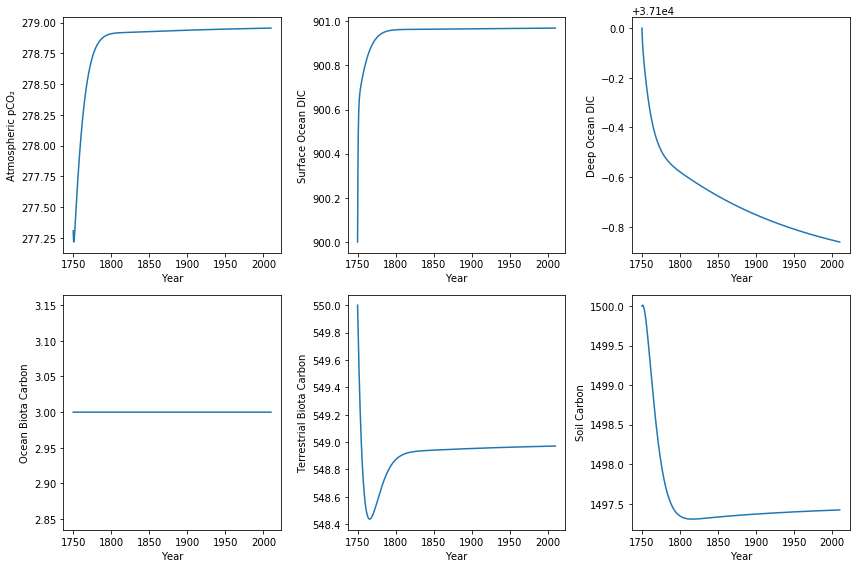

In [10]:
# Now the model has finished we can plot the results
# The following code makes a new figure with 6 subplots that show the
# variations in the major reservoirs (although pCO2 is used instead of CO2 
# in Gt as it's more intuitive)


# ----------------------------- # Plotting # -----------------------------

fig, axs = plt.subplots(2, 3, figsize=(12, 8)) 
axs[0, 0].plot(t, Atmospheric_pCO2)
axs[0, 0].set_xlabel("Year") 
axs[0, 0].set_ylabel("Atmospheric pCO₂")

axs[0, 1].plot(t, Surface_Ocean_DIC) 
axs[0, 1].set_xlabel("Year") 
axs[0, 1].set_ylabel("Surface Ocean DIC")

axs[0, 2].plot(t, Deep_Ocean_DIC) 
axs[0, 2].set_xlabel("Year") 
axs[0, 2].set_ylabel("Deep Ocean DIC")

axs[1, 0].plot(t, Ocean_Biota) 
axs[1, 0].set_xlabel("Year") 
axs[1, 0].set_ylabel("Ocean Biota Carbon") 

axs[1, 1].plot(t, Terrestrial_Biota) 
axs[1, 1].set_xlabel("Year") 
axs[1, 1].set_ylabel("Terrestrial Biota Carbon")

axs[1, 2].plot(t, Soil) 
axs[1, 2].set_xlabel("Year") 
axs[1, 2].set_ylabel("Soil Carbon")

plt.tight_layout() 
plt.show()


[1750.  1750.1 1750.2 ... 2009.7 2009.8 2009.9] [3.00000e-03 3.00000e-03 3.00000e-03 ... 7.72936e+00 7.73824e+00
 7.74712e+00]


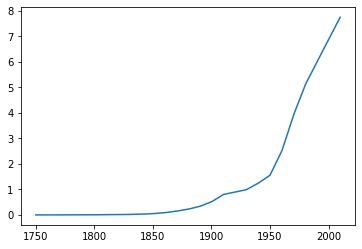